In [92]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

from scipy.linalg import expm

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Pauli
from qiskit.circuit.library import UnitaryGate, QFT

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
pi = np.pi

In [93]:
def create_hamiltonian(qubits, g, quiet=False):
    H = np.zeros((2**qubits, 2**qubits), dtype=np.complex128)

    # construct the Hamiltonian
    # with Pauli Operators in Qiskit ^ represents a tensor product
    if not quiet: print("H = ", end='')
    for i in range(qubits-1):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i or j == i+1):
                temp ^= Pauli('Z')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(temp)+" ", end='')
        H += -temp.to_matrix()
    for i in range(qubits):
        temp = Pauli('')
        for j in range(qubits):
            if (j == i):
                temp ^= Pauli('X')
            else:
                temp ^= Pauli('I')
        if not quiet: print("-"+str(g)+"*"+str(temp)+" ", end='')
        H += -g*temp.to_matrix()
    if not quiet: print("\n")
    
    scale_factor = (3/4) *pi
    # scale eigenvalues of the Hamiltonian
    eigenvalues,_ = np.linalg.eig(H)
    print(eigenvalues)
    H = scale_factor*H / np.linalg.norm(H, ord=2)
    
    # rotate matrix so that it will be positive definite
    # H += pi*np.eye(2**qubits)

    if not quiet: print("Eigenvalues of the Hamiltonian:\n", np.linalg.eigvals(H))
    min_eigenvalue = np.min(np.linalg.eigvals(H))
    if not quiet: print("Lowest energy Eigenvalue", min_eigenvalue); print()

    return H

def hadamard_test(ham, t, W = 'Re', g=0):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    if g>=1: qc.h(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    # print(qc)
    aer_sim = AerSimulator()
    trans_qc = transpile(qc, aer_sim)
    Nsample = 1000
    counts = aer_sim.run(trans_qc, shots = Nsample).result().get_counts()
    
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/Nsample
    meas = 2*p0-1
    return meas

def hadamard_test(ham, t, W = 'Re', g=0):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    if g>=1: qc.h(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    # print(qc)
    aer_sim = AerSimulator()
    trans_qc = transpile(qc, aer_sim)
    Nsample = 1000
    counts = aer_sim.run(trans_qc, shots = Nsample).result().get_counts()
    
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/Nsample
    meas = 2*p0-1
    return meas

def create_hadamard_test(ham, t, backend = AerSimulator(), W = 'Re', g=0):
    qr_ancilla = QuantumRegister(1)
    qr_eigenstate = QuantumRegister(np.log2(ham[0].shape[0]))
    cr = ClassicalRegister(1)
    qc = QuantumCircuit(qr_ancilla, qr_eigenstate, cr)
    qc.h(qr_ancilla)
    if g>=1: qc.h(qr_eigenstate)
    mat = expm(1j*ham*t)
    controlled_U = UnitaryGate(mat).control(annotated="yes")
    qc.append(controlled_U, qargs = [qr_ancilla[:]] + qr_eigenstate[:] )
    if W[0:1].upper() == 'IM' or W[0].upper() == 'S': qc.sdg(qr_ancilla)
    qc.h(qr_ancilla)
    qc.measure(qr_ancilla[0],cr[0])
    # print(qc)
    trans_qc = transpile(qc, backend)
    return trans_qc

def run_circuit(trans_qc, shots = 1000, backend = AerSimulator()):
    counts = backend.run(trans_qc, shots = shots).result().get_counts()
    p0 = 0
    if counts.get('0') is not None:
        p0 = counts['0']/shots
    meas = 2*p0-1
    return meas



In [116]:
def generate_s_k(ham, k, Dt, K, g=0): # small k should be used here (something needs to get fixed)
    # use real hadmard test to generate data
    s_k = [0 for _ in range(2*K+1)]
    for i in range(2*K+1):
        # print("generating s_k for Dt:", (i+1)*Dt)
        s_k[i] = hadamard_test(ham, (k+i)*Dt, g=g)
    # print(s_k)
    # s_k = [1,0,-1,0,1,0,-1,0,1]
    return s_k

def make_X(start, K, d, s_k = []):
    X = np.zeros((d, K+1))
    for i in range(len(X)):
        for j in range(len(X[i])):
            # print(i+j+start)
            X[i][j] = s_k[i+j+start]
    return X

def least_squares_regularization(X, noise_threshold):
    U, sigma, V = np.linalg.svd(X) # NOTE: V is returned daggered (figured that out way too late)
    threshold = noise_threshold*max(sigma)
    for l in range(len(sigma)):
        if sigma[l] <= threshold:
            sigma[l] = 0 # remove the singular value
            U[:,l] = 0   # remove the coorsponding column
            V[l,:] = 0   # remove the coorsponding row
    sigma_mat = np.zeros((U.shape[1], V.shape[0]))
    for l in range(len(sigma)):
        sigma_mat[l][l] = sigma[l]
    return U @ sigma_mat @ V

'''
Dt: time step for each iteration (Dt should not be small)
noise_threshold: used for linear regression
err_threshold: how close the energy until iterations have been stopped
K: number of time steps to take each iteration
alpha: used for calculating d  
est_E_0s: optinal list of collected E_0s
'''

def ODMD(ham, Dt, noise_threshold, K = 3, alpha = 1/2, est_E_0s = [], g=0): 
    k = 0
    # this is the suggested formula
    # d = math.floor(alpha*(K+1))
    d=3
    while (True):
        print("k =", k)
        # K = k+1
        if k*Dt > 2*pi: print("didn't work"); break
        s_k = generate_s_k(ham, k, Dt, K, g=g)
        X = make_X(0, K, d, s_k=s_k)
        # print("X\n",X)
        Xprime = make_X(1, K, d, s_k=s_k)
        # print("Xprime\n",Xprime) 
        X_sigma = least_squares_regularization(X, noise_threshold)
        # print("X_sigma\n",X_sigma)  
        A = Xprime @ np.linalg.pinv(X_sigma)
        # print("A\n",A)  
        eigenvalues,_ = np.linalg.eig(A)
        # print("eigenvalues\n", eigenvalues)
        eigenmax = max(eigenvalues, key=abs)
        # print("eigenmax =", eigenmax)
        angle = math.atan2(eigenmax.imag, eigenmax.real)
        # print("angle =", angle)
        E_0 = -angle/Dt
        est_E_0s.append(E_0)
        print("E_0 =", E_0)
        # if abs(old_E_0 - E_0) <= err_threshold: break
        k = k+1
    return E_0

def ODMD_new(ham, Dt, noise_threshold, K = 3, alpha = 1/2, est_E_0s = [], g=0): 
    
    # this is the suggested formula
    d = math.floor(alpha*(K+1))
    # d=3
    k = -1
    s_k = generate_s_k(ham, k, Dt, K, g=g)
    print(s_k)
    while (True):
        if k>38: break
        k=k+1
        print("k =", k)
        K = k-1
        d = math.floor(alpha*(K+1))
        if d < 1 or K < 1: continue
        if k*Dt > 2*pi: print("didn't work"); break
        s_k = generate_s_k(ham, k, Dt, K, g=g)
        X = make_X(0, K, d, s_k=s_k)
        print("X\n",X)
        Xprime = make_X(1, K, d, s_k=s_k)
        print("Xprime\n",Xprime) 
        X_sigma = least_squares_regularization(X, noise_threshold)
        print("X_sigma\n",X_sigma)  
        A = Xprime @ np.linalg.pinv(X_sigma)
        print("A\n",A)  
        eigenvalues,_ = np.linalg.eig(A)
        print("eigenvalues\n", eigenvalues)
        eigenmax = max(eigenvalues, key=abs)
        print("eigenmax =", eigenmax)
        angle = math.atan2(eigenmax.imag, eigenmax.real)
        print("angle =", angle)
        E_0 = -angle/Dt
        est_E_0s.append(E_0)
        print("E_0 =", E_0)
    return E_0

# g = 4
# Ham = create_hamiltonian(2, g)
# est_E_0s = []
# ODMD_new(Ham, .5, 0.01, est_E_0s = est_E_0s, g=g)

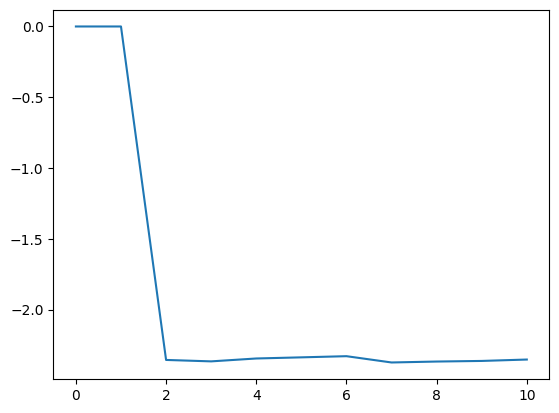

In [113]:
plt.plot(est_E_0s)

In [95]:
# from qiskit import qpy
# g = 1 
# Ham = create_hamiltonian(8, g)
# qcs = []
# Dt = .5
# K = 4
# for t in np.arange(0, 2*pi, Dt):
#     for i in range(2*K+1):
#         qcs.append(create_hadamard_test(Ham, (i+1)*t))
# with open("trial1.qpy", "wb") as file:
#     qpy.dump(qcs, file)

In [117]:
g = 4
Ham = create_hamiltonian(2, g)
trials = []
time_steps = [.1, .5, 1] # np.linspace(.01, 1.0, 4)
results = []
for i in time_steps:
    print(i)
    est_E_0s = []
    results.append(ODMD_new(Ham, i, 0.01, est_E_0s = est_E_0s, g=g))
    trials.append(est_E_0s)


H = -ZZ -4*XI -4*IX 

[ 8.06225775+0.j -1.        +0.j -8.06225775+0.j  1.        +0.j]
Eigenvalues of the Hamiltonian:
 [ 2.35619449+0.j -0.29224996+0.j -2.35619449+0.j  0.29224996+0.j]
Lowest energy Eigenvalue (-2.3561944901923444+0j)

0.1
[0.984, 1.0, 0.97, 0.8859999999999999, 0.764, 0.5920000000000001, 0.4119999999999999]
k = 0
k = 1
k = 2
X
 [[0.878 0.768]]
Xprime
 [[0.768 0.564]]
X_sigma
 [[0.878 0.768]]
A
 [[0.81388218]]
eigenvalues
 [0.81388218]
eigenmax = 0.8138821848625868
angle = 0.0
E_0 = -0.0
k = 3
X
 [[0.76  0.576 0.332]]
Xprime
 [[0.576 0.332 0.166]]
X_sigma
 [[0.76  0.576 0.332]]
A
 [[0.67095332]]
eigenvalues
 [0.67095332]
eigenmax = 0.6709533150255003
angle = 0.0
E_0 = -0.0
k = 4
X
 [[ 0.588  0.412  0.14  -0.092]
 [ 0.412  0.14  -0.092 -0.304]]
Xprime
 [[ 0.412  0.14  -0.092 -0.304]
 [ 0.14  -0.092 -0.304 -0.494]]
X_sigma
 [[ 0.588  0.412  0.14  -0.092]
 [ 0.412  0.14  -0.092 -0.304]]
A
 [[-3.63923204e-16  1.00000000e+00]
 [-9.65686179e-01  1.81638432e+00]]
eigenvalues

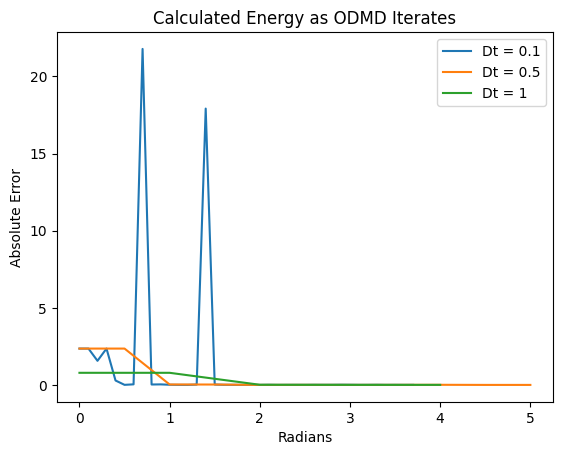

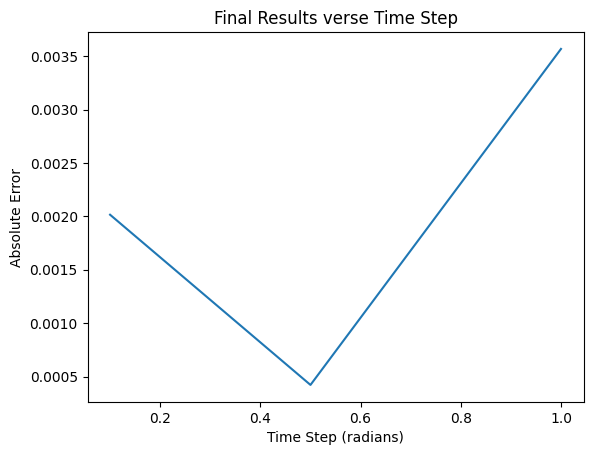

[-2.3582097472284467, -2.355773279228192, -2.3597626661342]


In [118]:
real_E_0 = -abs(np.linalg.eigvals(Ham)[0].real)
for i in range(len(trials)):
    err = [abs(w-real_E_0) for w in trials[i]]
    plt.plot(np.arange(0, 2*pi, time_steps[i])[0:len(trials[i])], err, label = 'Dt = '+str(time_steps[i]))
plt.title("Calculated Energy as ODMD Iterates")
plt.ylabel("Absolute Error")
plt.xlabel("Radians")
plt.legend()
# plt.ylim([-abs(np.linalg.eigvals(Ham)[0].real)+.5,-abs(np.linalg.eigvals(Ham)[0].real)-.5])
plt.savefig("Dt_vs_time.png")
plt.show()

plt.title("Final Results verse Time Step")
plt.xlabel("Time Step (radians)")
plt.ylabel("Absolute Error")
plt.plot(time_steps, [abs(real_E_0-i) for i in results])
# plt.ylim([-abs(np.linalg.eigvals(Ham)[0].real)+.5,-abs(np.linalg.eigvals(Ham)[0].real)-.5])
plt.show()
print(results)
 